# imports

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
from smiles.ketone_to_oximester import search_ketone, KetoneToOximester
from dataframe.load import load_csv
import warnings
warnings.simplefilter('ignore')

# 1. search ketone and replace it to oximesters

In [6]:
df_ald = load_csv('/Users/watanabeyuuya/OneDrive - 横浜国立大学/五東研究室/研究/IASO/stock_list_20220907115119_processed.csv')

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 29-30: invalid continuation byte

In [3]:
smiles = df_ald['Smiles']
print(len(smiles))

97


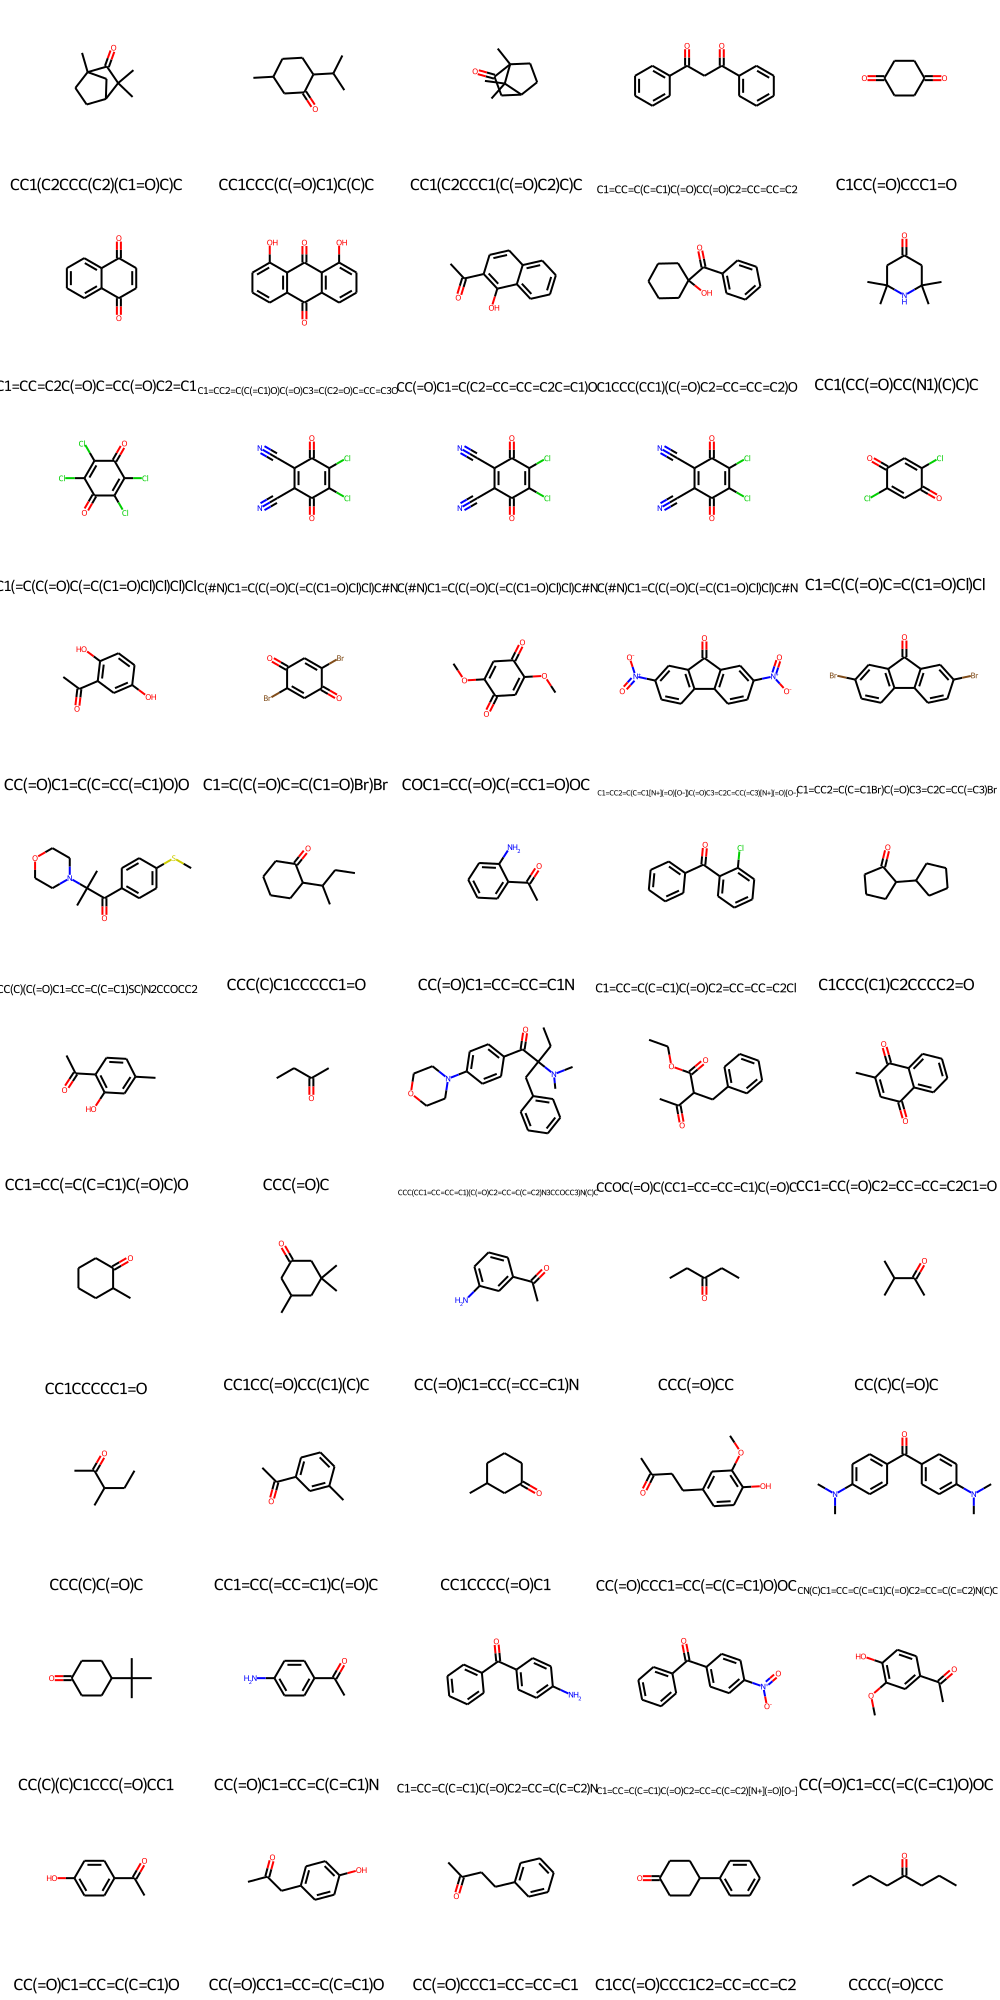

In [5]:
from smiles.grid_mol import grid_mols
from rdkit import Chem
from rdkit.Chem import Descriptors
smiles = smiles.values.tolist()
mols = [Chem.MolFromSmiles(x) for x in smiles]
smiles = [x for x in mols if Descriptors.NumAromaticRings(x) > 2]
grid_mols(smiles, row=5)

In [4]:
del df_ald

In [5]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit import Chem
ketones = []
CO_mol = Chem.MolFromSmiles('C=O')
for s in tqdm(smiles):
    mol = Chem.MolFromSmiles(s)
    # 条件: 分子量50以上 芳香環を持つ ケトン構造(=O)が一つのもの
    if search_ketone(s) and rdMolDescriptors._CalcMolWt(mol) > 50 and Descriptors.NumAromaticRings(mol) > 0 and len(mol.GetSubstructMatches(CO_mol)) == 1:
        ketones.append(s)
print('ketone: {} extraxted from : {} compounds'.format(len(ketones), len(smiles)))

  0%|          | 0/97 [00:00<?, ?it/s]

ketone: 39 extraxted from : 97 compounds


In [6]:
oxims = {}
for ketone in tqdm(ketones):
    oxim_list = []
    ketone_to_oxim = KetoneToOximester(ketone_smiles=ketone)
    replaced_ketones = ketone_to_oxim.replace()
    for replaced_ketone in replaced_ketones:
        oxim_list.append(replaced_ketone)
    oxims[ketone] = oxim_list

  0%|          | 0/39 [00:00<?, ?it/s]

In [7]:
print(len(oxims))

38


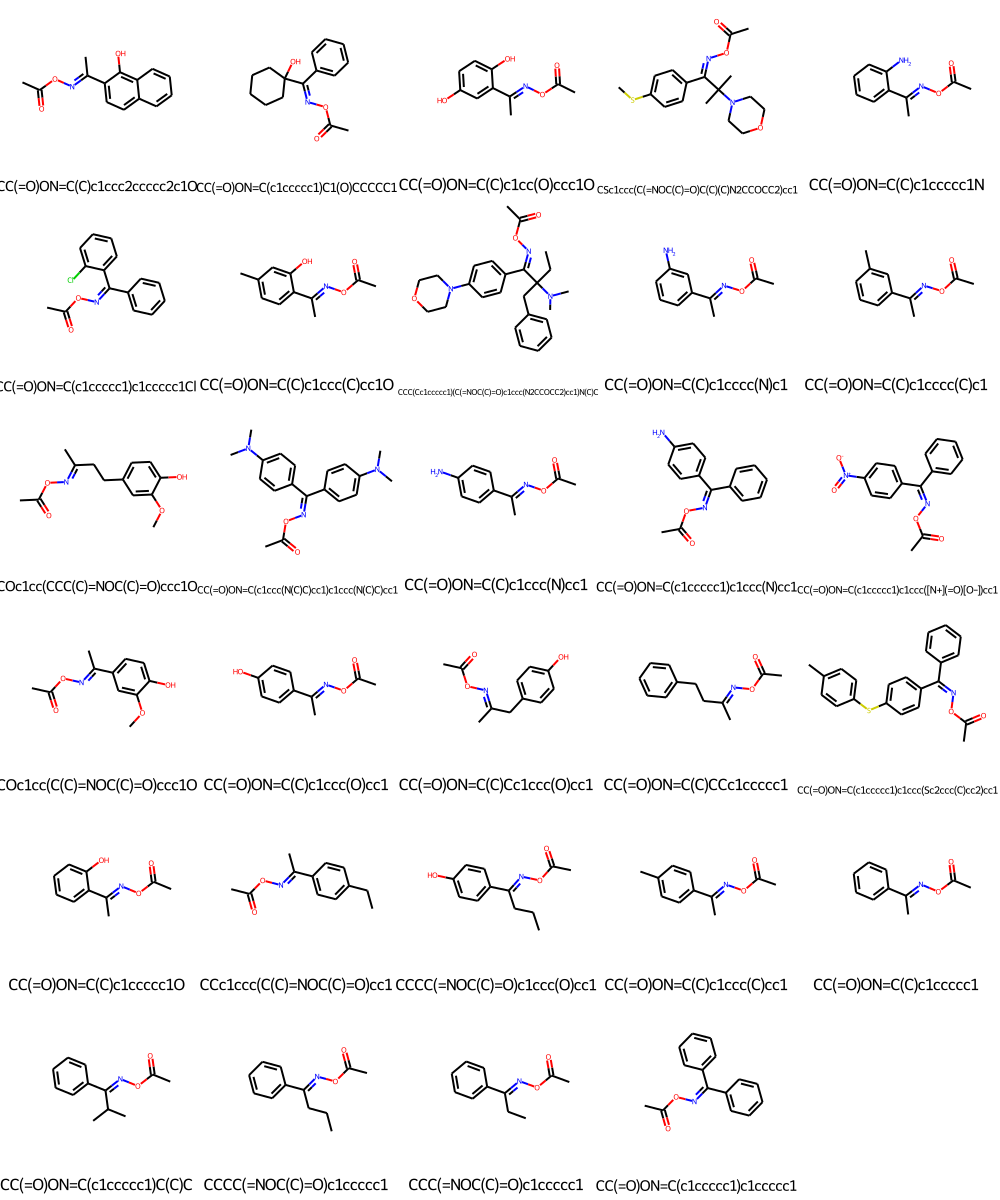

In [12]:
from smiles.grid_mol import grid_mols
smiles = []
for vals in oxims.values():
    for v in vals:
        smiles.append(v)
grid_mols(smiles, row=5)

In [14]:
for key, vals in oxims.items():
    for val in vals:
        if val == smiles[14]:
            print(key)

C1=CC=C(C=C1)C(=O)C2=CC=C(C=C2)[N+](=O)[O-]


In [8]:
from rdkit import Chem
from rdkit.Chem import Draw

In [9]:
mols = []
for oxs in list(oxims.values())[:50]:
    for ox in oxs:
        if ox:
            mol = Chem.MolFromSmiles(ox)
            mols.append(mol)

In [ ]:
import pickle
with open('./result/ketones/ketones.pickle', 'wb') as f:
    pickle.dump(oxims, f)

In [ ]:
import pickle
with open('./result/ketones/ketones.pickle', 'rb') as f:
    oxims = pickle.load(f)

In [10]:
oxes = []
for key, oxim_list in oxims.items():
    for v in oxim_list:
        oxes.append(v)
print(len(oxes))

6236


In [11]:
from descriptor.generator import DescriptorGenerator
generator = DescriptorGenerator(oxes)
df = generator.generator(None, None, None)
print(len(df))
df.head()

Descriptors generation has done!!
6236


,Smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CNCCCC(=NOC(C)=O)c1cccnc1,10.752210,-0.416660,10.752210,0.416660,0.349695,235.287,218.151,235.132077,92,...,0,0,0,0,0,0,0,0,1,0
1,CC(=O)ON=C(c1cccc(Cl)c1)C(C)NC(C)(C)C,10.978507,-0.451401,10.978507,0.088308,0.526289,296.798,275.630,296.129156,110,...,0,0,0,0,0,0,0,0,0,0
2,C=CC[N+](C)(C)c1ccc(CCC(CCc2ccc([N+](C)(C)CC=C...,11.319288,-0.392923,11.319288,0.392923,0.126073,463.666,422.338,463.318780,182,...,0,0,0,0,0,0,0,0,0,0
3,CNC(C)C(=NOC(C)=O)c1ccccc1,10.740729,-0.419691,10.740729,0.015509,0.475714,220.272,204.144,220.121178,86,...,0,0,0,0,0,0,0,0,0,0
4,CCCCc1oc2ccccc2c1C(=NOC(C)=O)c1cc(I)c(OCCN(CC)...,11.700746,-0.466520,11.700746,0.466520,0.087958,702.371,670.115,702.045154,188,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df.to_csv('./data/syn_oxims.csv')

In [1]:
from neural_network.networks.dense_network import ABS_estimator
import torch
device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")
model_path = './neural_network/model/model_NN_absorbance_label.pth'
model = ABS_estimator().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [2]:
from dataframe.load import load_csv
df = load_csv('./data/syn_oxims.csv')
print(len(df))
df.head()

6236


,Smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CNCCCC(=NOC(C)=O)c1cccnc1,10.752210,-0.416660,10.752210,0.416660,0.349695,235.287,218.151,235.132077,92,...,0,0,0,0,0,0,0,0,1,0
1,CC(=O)ON=C(c1cccc(Cl)c1)C(C)NC(C)(C)C,10.978507,-0.451401,10.978507,0.088308,0.526289,296.798,275.630,296.129156,110,...,0,0,0,0,0,0,0,0,0,0
2,C=CC[N+](C)(C)c1ccc(CCC(CCc2ccc([N+](C)(C)CC=C...,11.319288,-0.392923,11.319288,0.392923,0.126073,463.666,422.338,463.318780,182,...,0,0,0,0,0,0,0,0,0,0
3,CNC(C)C(=NOC(C)=O)c1ccccc1,10.740729,-0.419691,10.740729,0.015509,0.475714,220.272,204.144,220.121178,86,...,0,0,0,0,0,0,0,0,0,0
4,CCCCc1oc2ccccc2c1C(=NOC(C)=O)c1cc(I)c(OCCN(CC)...,11.700746,-0.466520,11.700746,0.466520,0.087958,702.371,670.115,702.045154,188,...,0,0,0,0,0,0,0,0,0,0


In [9]:
x = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float).to(device)
print(x[0].size(), len(x))

torch.Size([208]) 6236


In [16]:
splited_xs = torch.split(x, 50, dim=0)
pred_labels = []
for X in splited_xs:
    pred = model(X)
    labels = torch.round(pred)
    labels = labels.to('cpu').detach().numpy().copy()
    for l in labels:
        pred_labels.append(l[0])

In [17]:
df['abs_pred'] = pred_labels
df.head()

,Smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,abs_pred
0,CNCCCC(=NOC(C)=O)c1cccnc1,10.752210,-0.416660,10.752210,0.416660,0.349695,235.287,218.151,235.132077,92,...,0,0,0,0,0,0,0,1,0,0.0
1,CC(=O)ON=C(c1cccc(Cl)c1)C(C)NC(C)(C)C,10.978507,-0.451401,10.978507,0.088308,0.526289,296.798,275.630,296.129156,110,...,0,0,0,0,0,0,0,0,0,0.0
2,C=CC[N+](C)(C)c1ccc(CCC(CCc2ccc([N+](C)(C)CC=C...,11.319288,-0.392923,11.319288,0.392923,0.126073,463.666,422.338,463.318780,182,...,0,0,0,0,0,0,0,0,0,1.0
3,CNC(C)C(=NOC(C)=O)c1ccccc1,10.740729,-0.419691,10.740729,0.015509,0.475714,220.272,204.144,220.121178,86,...,0,0,0,0,0,0,0,0,0,0.0
4,CCCCc1oc2ccccc2c1C(=NOC(C)=O)c1cc(I)c(OCCN(CC)...,11.700746,-0.466520,11.700746,0.466520,0.087958,702.371,670.115,702.045154,188,...,0,0,0,0,0,0,0,0,0,1.0


In [ ]:
df[df['abs_pred'] ]

In [5]:
pred_label = torch.round(pred)

In [6]:
df['abs_pred'] = pred.to('cpu').detach().numpy().copy()
df.head()

,Smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,abs_pred
0,CNCCCC(=NOC(C)=O)c1cccnc1,10.752210,-0.416660,10.752210,0.416660,0.349695,235.287,218.151,235.132077,92,...,0,0,0,0,0,0,0,1,0,1.0
1,CC(=O)ON=C(c1cccc(Cl)c1)C(C)NC(C)(C)C,10.978507,-0.451401,10.978507,0.088308,0.526289,296.798,275.630,296.129156,110,...,0,0,0,0,0,0,0,0,0,1.0
2,C=CC[N+](C)(C)c1ccc(CCC(CCc2ccc([N+](C)(C)CC=C...,11.319288,-0.392923,11.319288,0.392923,0.126073,463.666,422.338,463.318780,182,...,0,0,0,0,0,0,0,0,0,1.0
3,CNC(C)C(=NOC(C)=O)c1ccccc1,10.740729,-0.419691,10.740729,0.015509,0.475714,220.272,204.144,220.121178,86,...,0,0,0,0,0,0,0,0,0,1.0
4,CCCCc1oc2ccccc2c1C(=NOC(C)=O)c1cc(I)c(OCCN(CC)...,11.700746,-0.466520,11.700746,0.466520,0.087958,702.371,670.115,702.045154,188,...,0,0,0,0,0,0,0,0,0,1.0


In [7]:
df = df[df['abs_pred'] == 1]
print(len(df))
df.head()

6230


,Smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,abs_pred
0,CNCCCC(=NOC(C)=O)c1cccnc1,10.752210,-0.416660,10.752210,0.416660,0.349695,235.287,218.151,235.132077,92,...,0,0,0,0,0,0,0,1,0,1.0
1,CC(=O)ON=C(c1cccc(Cl)c1)C(C)NC(C)(C)C,10.978507,-0.451401,10.978507,0.088308,0.526289,296.798,275.630,296.129156,110,...,0,0,0,0,0,0,0,0,0,1.0
2,C=CC[N+](C)(C)c1ccc(CCC(CCc2ccc([N+](C)(C)CC=C...,11.319288,-0.392923,11.319288,0.392923,0.126073,463.666,422.338,463.318780,182,...,0,0,0,0,0,0,0,0,0,1.0
3,CNC(C)C(=NOC(C)=O)c1ccccc1,10.740729,-0.419691,10.740729,0.015509,0.475714,220.272,204.144,220.121178,86,...,0,0,0,0,0,0,0,0,0,1.0
4,CCCCc1oc2ccccc2c1C(=NOC(C)=O)c1cc(I)c(OCCN(CC)...,11.700746,-0.466520,11.700746,0.466520,0.087958,702.371,670.115,702.045154,188,...,0,0,0,0,0,0,0,0,0,1.0


In [ ]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from smiles.ketone_to_oximester import search_ketone
from tqdm.notebook import tqdm
smiles = df['Smiles'].values.tolist()
substituents = ['[O-][N+]=O', 'F', 'Cl', 'Br', 'I', '*[OH]', '*[NH2]']
extracted = []
for s in tqdm(smiles):
    mol = Chem.MolFromSmiles(s)
    if rdMolDescriptors._CalcMolWt(mol) > 100 and Descriptors.NumAromaticRings(mol) > 2:
        checker = []
        for i, sub in enumerate(substituents):
            sub_mol = Chem.MolFromSmarts(sub)
            if mol.HasSubstructMatch(sub_mol):
                checker.append(sub)
            if i == len(substituents) - 1 and len(checker) == 0:
                extracted.append(s)

In [ ]:
print(len(extracted))

In [ ]:
from smiles.grid_mol import grid_mols
grid_mols(extracted, row=5)

# 2. Absorbance

## 2-1. dataframe

In [ ]:
import pickle
with open('./result/ketones/ketones.pickle', 'rb') as f:
    oxims = pickle.load(f)

In [ ]:
oxim_l = list(oxims.values())
oxim_list = []
for x in oxim_l:
    for y in x:
        if y:
            oxim_list.append(y)
print(len(oxim_list))

In [ ]:
from descriptor.fingeprint_from_smiles import smiles_list_to_fingerprint_dataframe
from dotenv import load_dotenv
load_dotenv()
import os

In [ ]:
df_abs = smiles_list_to_fingerprint_dataframe(oxim_list, radius=int(os.environ['RADIUS_abs']), nBits=int(os.environ['NBITS_abs']))
df_abs.head()

## 2-2. predict

In [ ]:
x = df_abs.iloc[:, 1:].values
print(len(x[0]))

In [ ]:
import pickle
with open('./xgboost_/model/xgb_model_absorbance_label.pickle', 'rb') as f:
    model = pickle.load(f)

In [ ]:
labels = model.predict(x)
print(len(labels))

In [ ]:
df_abs['pred_abs'] = labels
df_abs.head()

In [ ]:
df_abs[df_abs['pred_abs'] == 1]

In [ ]:
df_abs.to_csv('./data/oximester_pred_abs_IASO.csv')

In [ ]:
target = df_abs.iloc[14, 0]
Chem.MolFromSmiles(target)

In [ ]:
for k, vs in oxims.items():
    for v in vs:
        if v == target:
            print(k)
            break